In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import collections
import nltk
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import regex as re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, GlobalAveragePooling1D, Conv1D, Bidirectional
import matplotlib.pyplot as plt

In [ ]:
# input and output dir for load and save data
input_dir = '/content/drive/My Drive/Colab Notebooks/Suicide and Depression/data/input/'
output_dir = '/content/drive/My Drive/Colab Notebooks/Suicide and Depression/data/output/'
model_dir = '/content/drive/My Drive/Colab Notebooks/Suicide and Depression/saved_model/'


In [ ]:
#load Data
data=pd.read_csv(output_dir+'final_data_processed_pre.csv')
data.head()

,date,subreddit,text,text_lemma,text_stem,text_spacy,pre_text,pre_text_lemma,pre_text_stem,pre_text_spacy
0,2022/12/23,1,regret committed suicide back may regret allow...,regret committed suicide back may regret allow...,regret commit suicid back may regret allow pil...,regret commit suicide back may regret allow pi...,"['regret', 'committed', 'suicide', 'back', 'ma...","['regret', 'committed', 'suicide', 'back', 'ma...","['regret', 'commit', 'suicid', 'back', 'may', ...","['regret', 'commit', 'suicide', 'back', 'may',..."
1,2022/12/23,0,ok medication working damage life depression l...,ok medication working damage life depression l...,ok medic work damag life depress lost friend b...,ok medication working damage life depression l...,"['ok', 'medication', 'working', 'damage', 'lif...","['ok', 'medication', 'working', 'damage', 'lif...","['ok', 'medic', 'work', 'damag', 'life', 'depr...","['ok', 'medication', 'working', 'damage', 'lif..."
2,2022/12/29,0,venting hate life idk many people going see go...,venting hate life idk many people going see go...,vent hate life idk mani peopl go see go alway ...,venting hate life idk many people go see go al...,"['venting', 'hate', 'life', 'idk', 'many', 'pe...","['venting', 'hate', 'life', 'idk', 'many', 'pe...","['vent', 'hate', 'life', 'idk', 'mani', 'peopl...","['venting', 'hate', 'life', 'idk', 'many', 'pe..."
3,2022/12/12,1,problem issues nothing live want kill justifia...,problem issue nothing live want kill justifiab...,problem issu noth live want kill justifi reaso...,problem issue nothing live want kill justifiab...,"['problem', 'issues', 'nothing', 'live', 'want...","['problem', 'issue', 'nothing', 'live', 'want'...","['problem', 'issu', 'noth', 'live', 'want', 'k...","['problem', 'issue', 'nothing', 'live', 'want'..."
4,2022/12/09,0,living survive apprehensive realm hereafter th...,living survive apprehensive realm hereafter th...,live surviv apprehens realm hereaft thing keep...,live survive apprehensive realm hereaft thing ...,"['living', 'survive', 'apprehensive', 'realm',...","['living', 'survive', 'apprehensive', 'realm',...","['live', 'surviv', 'apprehens', 'realm', 'here...","['live', 'survive', 'apprehensive', 'realm', '..."


**Preparing testing and Training data and model selection**

In [ ]:
def loss_accuracy_graph(history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
  axes[0].plot(history.history['loss'],label="loss")
  axes[0].plot(history.history['val_loss'],label="val loss")
  axes[0].legend()
  axes[1].plot(history.history['accuracy'],label="accuracy")
  axes[1].plot(history.history['val_accuracy'],label="val accuracy")
  axes[1].legend()

In [ ]:
def confusion_matrix_report(model, testing_padded, y_test):
  labels=["Depresion","Suicide"]
  y_pred = model.predict(testing_padded)
  y_pred = np.argmax(y_pred, axis=1)
  print(classification_report(np.array(y_test),y_pred))
  confusion_mtx = confusion_matrix(np.array(y_test),y_pred)
  f,ax = plt.subplots(figsize=(15, 10))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
def model_func(model_type, data_type, epochs=10):
  text=data[data_type]
  label=data['subreddit']
  X_train, X_test, y_train, y_test = train_test_split(text, np.array(label), test_size=0.30, random_state=100)

  vocab_size = 50000
  embedding_dim = 50
  max_length = 500
  trunc_type='post'
  padding_type='post'
  oov_tok = ""

  tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(X_train)

  word_index = tokenizer.word_index

  x_train_sequ = tokenizer.texts_to_sequences(X_train)
  training_padded = pad_sequences(x_train_sequ, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  training_padded = np.array(training_padded)

  x_test_sequ = tokenizer.texts_to_sequences(X_test)
  testing_padded = pad_sequences(x_test_sequ, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  testing_padded = np.array(testing_padded)

  if model_type == 'dnn':
      model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
      ])
  elif model_type == 'ConvLSTM':
      model = Sequential([
          Embedding(vocab_size, embedding_dim, input_length=max_length),
          Conv1D(6,12, activation='relu'),
          Bidirectional(LSTM(13, dropout=0.2, recurrent_dropout=0.2)),
          Dense(64, activation='relu'),
          Dense(2, activation='softmax')
      ])
  elif model_type == 'rnn':
      model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(6, dropout=0.2, recurrent_dropout=0.2)),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
      
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
      
  history = model.fit(training_padded, y_train, epochs=epochs, validation_data=(testing_padded, y_test))

  model.save(model_dir+'model_'+model_type+'_'+data_type+'.h5')

  loss_accuracy_graph(history)

  confusion_matrix_report(model, testing_padded, y_test)


In [ ]:
data.head()

,date,subreddit,text,text_lemma,text_stem,text_spacy,pre_text,pre_text_lemma,pre_text_stem,pre_text_spacy
0,2022/12/23,1,regret committed suicide back may regret allow...,regret committed suicide back may regret allow...,regret commit suicid back may regret allow pil...,regret commit suicide back may regret allow pi...,"['regret', 'committed', 'suicide', 'back', 'ma...","['regret', 'committed', 'suicide', 'back', 'ma...","['regret', 'commit', 'suicid', 'back', 'may', ...","['regret', 'commit', 'suicide', 'back', 'may',..."
1,2022/12/23,0,ok medication working damage life depression l...,ok medication working damage life depression l...,ok medic work damag life depress lost friend b...,ok medication working damage life depression l...,"['ok', 'medication', 'working', 'damage', 'lif...","['ok', 'medication', 'working', 'damage', 'lif...","['ok', 'medic', 'work', 'damag', 'life', 'depr...","['ok', 'medication', 'working', 'damage', 'lif..."
2,2022/12/29,0,venting hate life idk many people going see go...,venting hate life idk many people going see go...,vent hate life idk mani peopl go see go alway ...,venting hate life idk many people go see go al...,"['venting', 'hate', 'life', 'idk', 'many', 'pe...","['venting', 'hate', 'life', 'idk', 'many', 'pe...","['vent', 'hate', 'life', 'idk', 'mani', 'peopl...","['venting', 'hate', 'life', 'idk', 'many', 'pe..."
3,2022/12/12,1,problem issues nothing live want kill justifia...,problem issue nothing live want kill justifiab...,problem issu noth live want kill justifi reaso...,problem issue nothing live want kill justifiab...,"['problem', 'issues', 'nothing', 'live', 'want...","['problem', 'issue', 'nothing', 'live', 'want'...","['problem', 'issu', 'noth', 'live', 'want', 'k...","['problem', 'issue', 'nothing', 'live', 'want'..."
4,2022/12/09,0,living survive apprehensive realm hereafter th...,living survive apprehensive realm hereafter th...,live surviv apprehens realm hereaft thing keep...,live survive apprehensive realm hereaft thing ...,"['living', 'survive', 'apprehensive', 'realm',...","['living', 'survive', 'apprehensive', 'realm',...","['live', 'surviv', 'apprehens', 'realm', 'here...","['live', 'survive', 'apprehensive', 'realm', '..."



#DNN

1) DNN model with normal text

Epoch 1/10
322/322 [==============================] - 15s 43ms/step - loss: 0.6872 - accuracy: 0.5592 - val_loss: 0.6665 - val_accuracy: 0.6605
Epoch 2/10
322/322 [==============================] - 13s 41ms/step - loss: 0.5942 - accuracy: 0.7057 - val_loss: 0.5599 - val_accuracy: 0.7249
Epoch 3/10
322/322 [==============================] - 13s 42ms/step - loss: 0.5033 - accuracy: 0.7584 - val_loss: 0.5486 - val_accuracy: 0.7253
Epoch 4/10
322/322 [==============================] - 13s 40ms/step - loss: 0.4487 - accuracy: 0.7962 - val_loss: 0.5515 - val_accuracy: 0.7437
Epoch 5/10
322/322 [==============================] - 13s 40ms/step - loss: 0.4115 - accuracy: 0.8171 - val_loss: 0.5716 - val_accuracy: 0.7265
Epoch 6/10
322/322 [==============================] - 13s 42ms/step - loss: 0.3764 - accuracy: 0.8318 - val_loss: 0.5968 - val_accuracy: 0.7206
Epoch 7/10
322/322 [==============================] - 13s 39ms/step - loss: 0.3453 - accuracy: 0.8485 - val_loss: 0.6266 - val_accuracy:

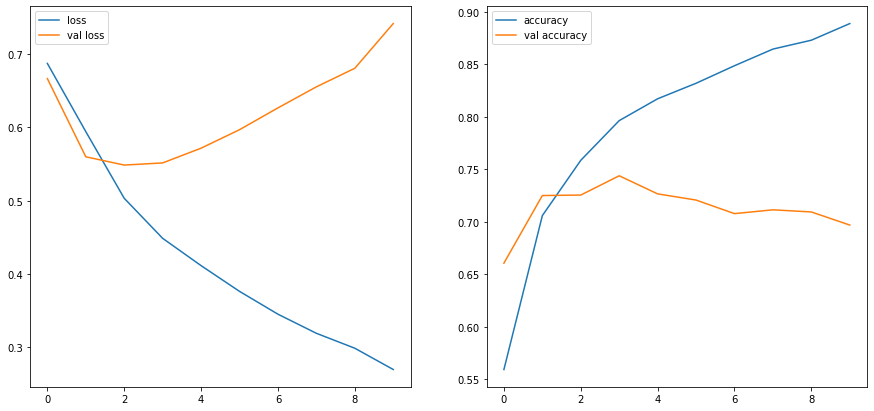

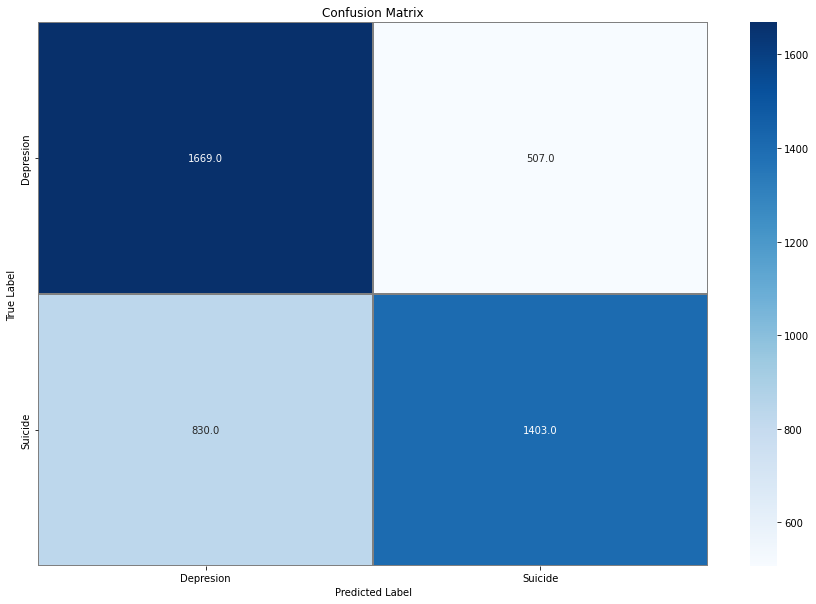

In [ ]:
model_func('dnn', 'pre_text', epochs=10)

2) DNN model with text lemmatize

Epoch 1/10
322/322 [==============================] - 15s 44ms/step - loss: 0.6883 - accuracy: 0.5512 - val_loss: 0.6761 - val_accuracy: 0.5650
Epoch 2/10
322/322 [==============================] - 13s 42ms/step - loss: 0.6021 - accuracy: 0.7029 - val_loss: 0.5686 - val_accuracy: 0.7147
Epoch 3/10
322/322 [==============================] - 14s 43ms/step - loss: 0.5073 - accuracy: 0.7564 - val_loss: 0.5489 - val_accuracy: 0.7353
Epoch 4/10
322/322 [==============================] - 14s 44ms/step - loss: 0.4601 - accuracy: 0.7915 - val_loss: 0.5458 - val_accuracy: 0.7403
Epoch 5/10
322/322 [==============================] - 14s 44ms/step - loss: 0.4228 - accuracy: 0.8116 - val_loss: 0.5641 - val_accuracy: 0.7328
Epoch 6/10
322/322 [==============================] - 14s 43ms/step - loss: 0.3965 - accuracy: 0.8221 - val_loss: 0.5857 - val_accuracy: 0.7256
Epoch 7/10
322/322 [==============================] - 14s 43ms/step - loss: 0.3661 - accuracy: 0.8425 - val_loss: 0.6561 - val_accuracy:

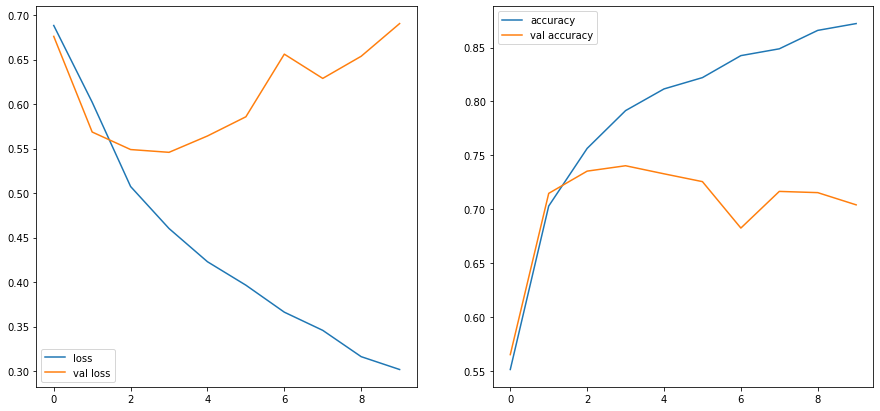

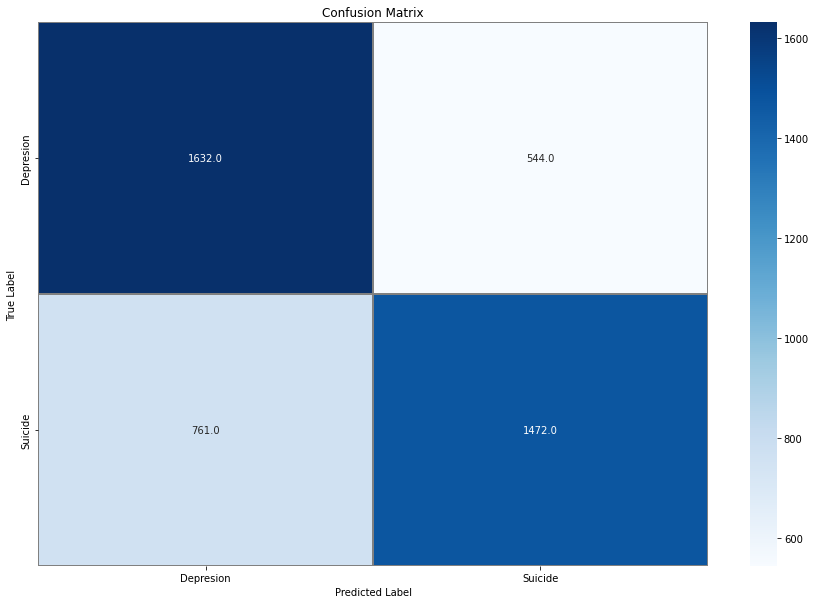

In [ ]:
model_func('dnn', 'pre_text_lemma', epochs=10)

3) DNN model with stemming text

Epoch 1/10
322/322 [==============================] - 13s 39ms/step - loss: 0.6857 - accuracy: 0.5554 - val_loss: 0.6606 - val_accuracy: 0.6355
Epoch 2/10
322/322 [==============================] - 12s 37ms/step - loss: 0.5870 - accuracy: 0.7134 - val_loss: 0.5550 - val_accuracy: 0.7360
Epoch 3/10
322/322 [==============================] - 12s 38ms/step - loss: 0.5071 - accuracy: 0.7625 - val_loss: 0.5606 - val_accuracy: 0.7174
Epoch 4/10
322/322 [==============================] - 13s 39ms/step - loss: 0.4755 - accuracy: 0.7764 - val_loss: 0.5495 - val_accuracy: 0.7378
Epoch 5/10
322/322 [==============================] - 13s 39ms/step - loss: 0.4435 - accuracy: 0.8003 - val_loss: 0.5498 - val_accuracy: 0.7405
Epoch 6/10
322/322 [==============================] - 13s 40ms/step - loss: 0.4256 - accuracy: 0.8082 - val_loss: 0.5948 - val_accuracy: 0.7061
Epoch 7/10
322/322 [==============================] - 14s 43ms/step - loss: 0.4015 - accuracy: 0.8203 - val_loss: 0.5857 - val_accuracy:

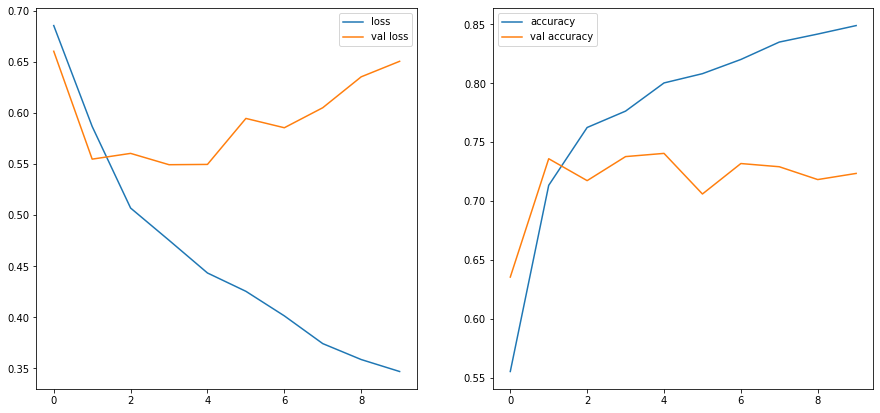

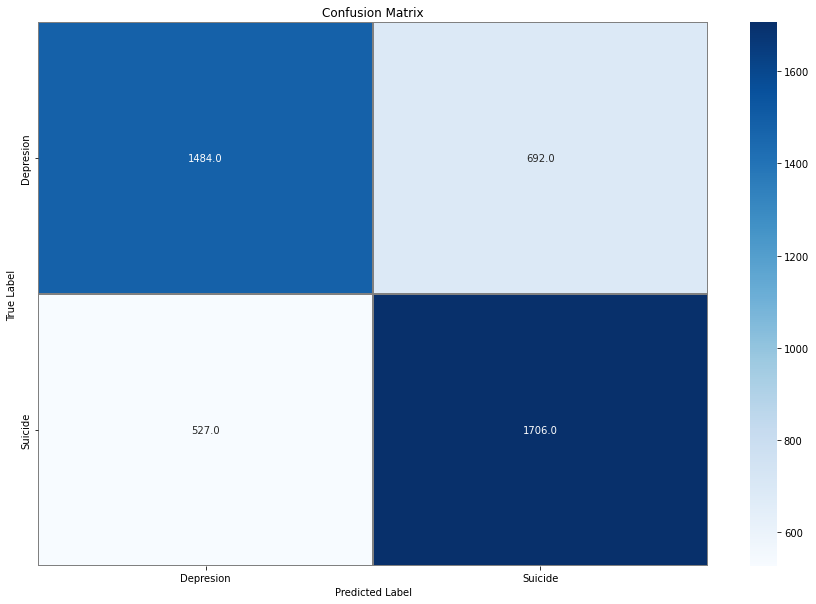

In [ ]:
model_func('dnn', 'pre_text_stem', epochs=10)

4) DNN model with spacy emmatize text

Epoch 1/10
322/322 [==============================] - 15s 44ms/step - loss: 0.6864 - accuracy: 0.5492 - val_loss: 0.6643 - val_accuracy: 0.6360
Epoch 2/10
322/322 [==============================] - 13s 40ms/step - loss: 0.6007 - accuracy: 0.6924 - val_loss: 0.5641 - val_accuracy: 0.7326
Epoch 3/10
322/322 [==============================] - 13s 39ms/step - loss: 0.5133 - accuracy: 0.7551 - val_loss: 0.5478 - val_accuracy: 0.7378
Epoch 4/10
322/322 [==============================] - 13s 41ms/step - loss: 0.4696 - accuracy: 0.7826 - val_loss: 0.5626 - val_accuracy: 0.7290
Epoch 5/10
322/322 [==============================] - 13s 41ms/step - loss: 0.4407 - accuracy: 0.7995 - val_loss: 0.5650 - val_accuracy: 0.7317
Epoch 6/10
322/322 [==============================] - 14s 42ms/step - loss: 0.4109 - accuracy: 0.8185 - val_loss: 0.5849 - val_accuracy: 0.7231
Epoch 7/10
322/322 [==============================] - 14s 44ms/step - loss: 0.3876 - accuracy: 0.8284 - val_loss: 0.5860 - val_accuracy:

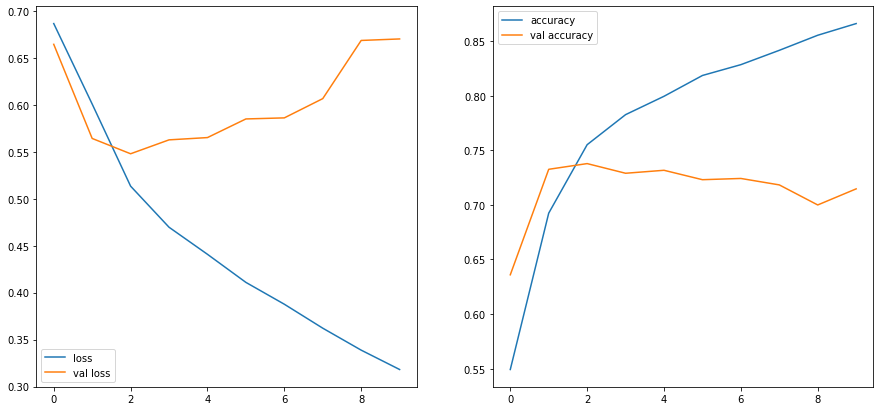

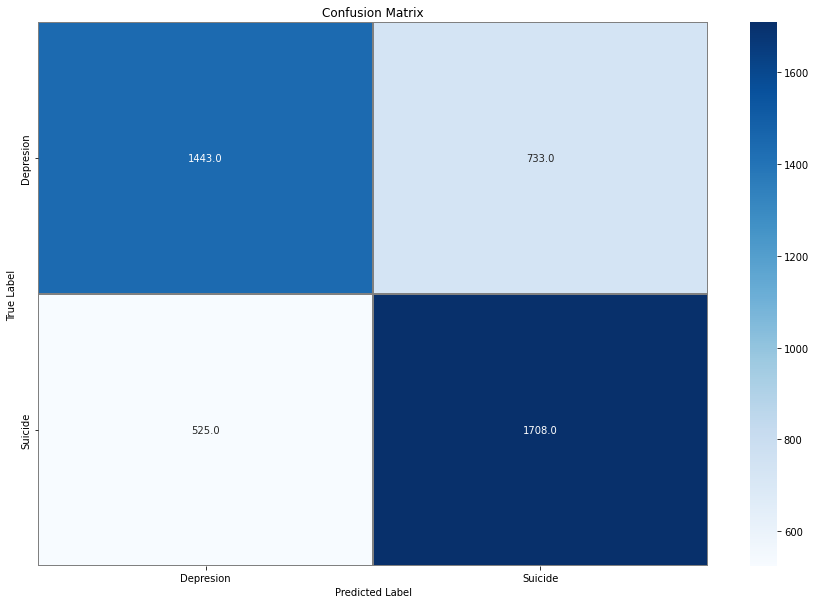

In [ ]:
model_func('dnn', 'pre_text_spacy', epochs=10)


#ConvLSTM 

5) ConvLSTM model with normal text

Epoch 1/7
322/322 [==============================] - 362s 1s/step - loss: 0.6149 - accuracy: 0.6522 - val_loss: 0.5571 - val_accuracy: 0.7120
Epoch 2/7
322/322 [==============================] - 347s 1s/step - loss: 0.4534 - accuracy: 0.7950 - val_loss: 0.5840 - val_accuracy: 0.7097
Epoch 3/7
322/322 [==============================] - 358s 1s/step - loss: 0.3026 - accuracy: 0.8736 - val_loss: 0.7285 - val_accuracy: 0.6850
Epoch 4/7
322/322 [==============================] - 358s 1s/step - loss: 0.1781 - accuracy: 0.9312 - val_loss: 0.9621 - val_accuracy: 0.6727
Epoch 5/7
322/322 [==============================] - 367s 1s/step - loss: 0.1084 - accuracy: 0.9592 - val_loss: 1.1577 - val_accuracy: 0.6732
Epoch 6/7
322/322 [==============================] - 359s 1s/step - loss: 0.0757 - accuracy: 0.9719 - val_loss: 1.4815 - val_accuracy: 0.6675
Epoch 7/7
138/138 [==============================] - 19s 125ms/step
              precision    recall  f1-score   support

           0       0.63  

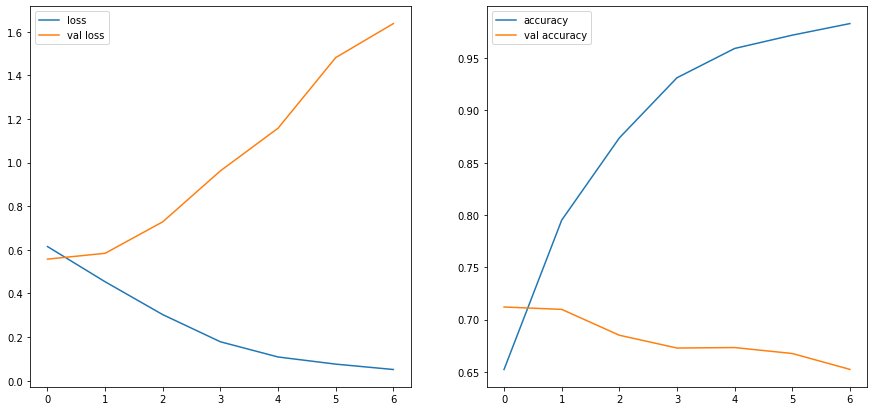

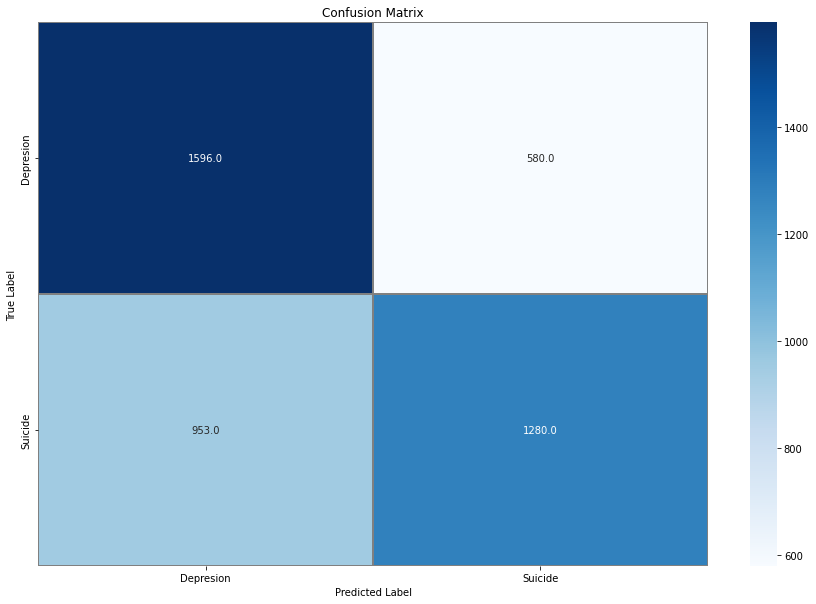

In [ ]:
model_func('ConvLSTM', 'pre_text', epochs=7)

6) ConvLSTM model with text lemmatize

Epoch 1/7
322/322 [==============================] - 371s 1s/step - loss: 0.6218 - accuracy: 0.6352 - val_loss: 0.5495 - val_accuracy: 0.7160
Epoch 2/7
322/322 [==============================] - 367s 1s/step - loss: 0.4650 - accuracy: 0.7848 - val_loss: 0.5637 - val_accuracy: 0.7190
Epoch 3/7
322/322 [==============================] - 362s 1s/step - loss: 0.3365 - accuracy: 0.8574 - val_loss: 0.6879 - val_accuracy: 0.6986
Epoch 4/7
322/322 [==============================] - 359s 1s/step - loss: 0.2143 - accuracy: 0.9161 - val_loss: 0.8435 - val_accuracy: 0.6831
Epoch 5/7
322/322 [==============================] - 358s 1s/step - loss: 0.1292 - accuracy: 0.9558 - val_loss: 1.1879 - val_accuracy: 0.6732
Epoch 6/7
322/322 [==============================] - 362s 1s/step - loss: 0.0838 - accuracy: 0.9706 - val_loss: 1.3648 - val_accuracy: 0.6707
Epoch 7/7
138/138 [==============================] - 18s 129ms/step
              precision    recall  f1-score   support

           0       0.66  

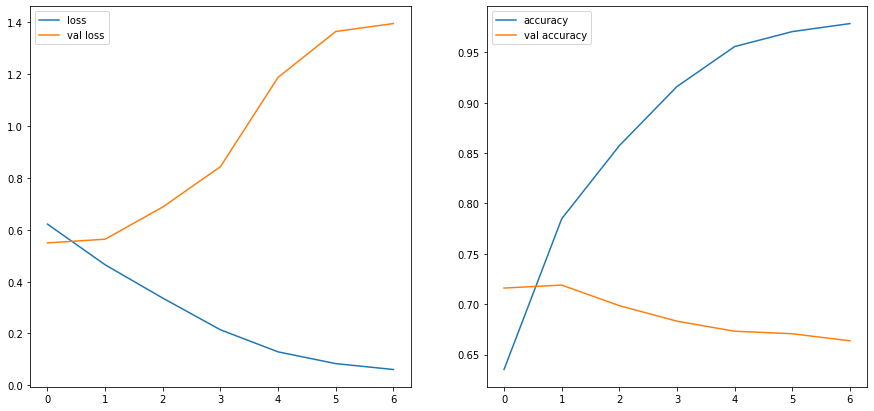

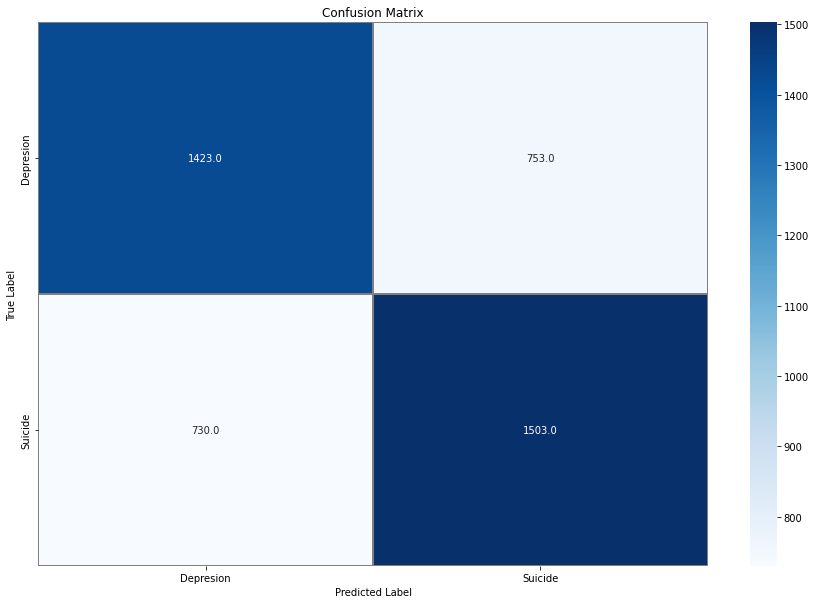

In [ ]:
model_func('ConvLSTM', 'pre_text_lemma', epochs=7)

7) ConvLSTM model with stemming text

Epoch 1/7
322/322 [==============================] - 365s 1s/step - loss: 0.6105 - accuracy: 0.6615 - val_loss: 0.5428 - val_accuracy: 0.7267
Epoch 2/7
322/322 [==============================] - 365s 1s/step - loss: 0.4757 - accuracy: 0.7821 - val_loss: 0.5604 - val_accuracy: 0.7228
Epoch 3/7
322/322 [==============================] - 356s 1s/step - loss: 0.3651 - accuracy: 0.8471 - val_loss: 0.6484 - val_accuracy: 0.6940
Epoch 4/7
322/322 [==============================] - 354s 1s/step - loss: 0.2498 - accuracy: 0.9008 - val_loss: 0.8523 - val_accuracy: 0.6825
Epoch 5/7
322/322 [==============================] - 353s 1s/step - loss: 0.1654 - accuracy: 0.9381 - val_loss: 1.0666 - val_accuracy: 0.6720
Epoch 6/7
322/322 [==============================] - 353s 1s/step - loss: 0.1174 - accuracy: 0.9584 - val_loss: 1.1599 - val_accuracy: 0.6686
Epoch 7/7
138/138 [==============================] - 17s 119ms/step
              precision    recall  f1-score   support

           0       0.67  

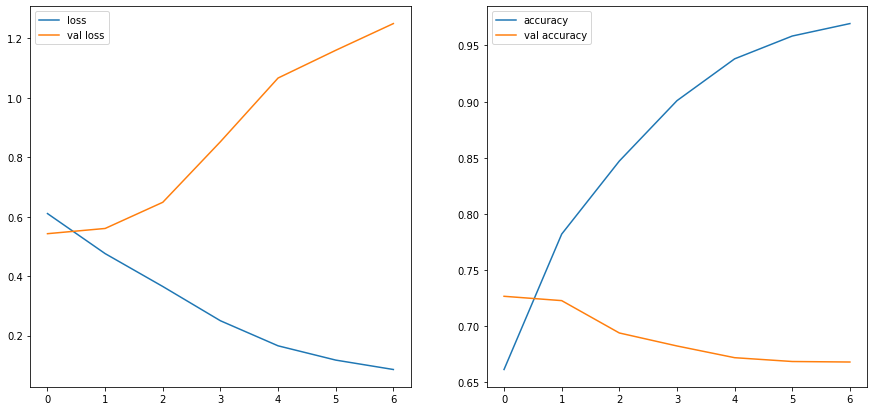

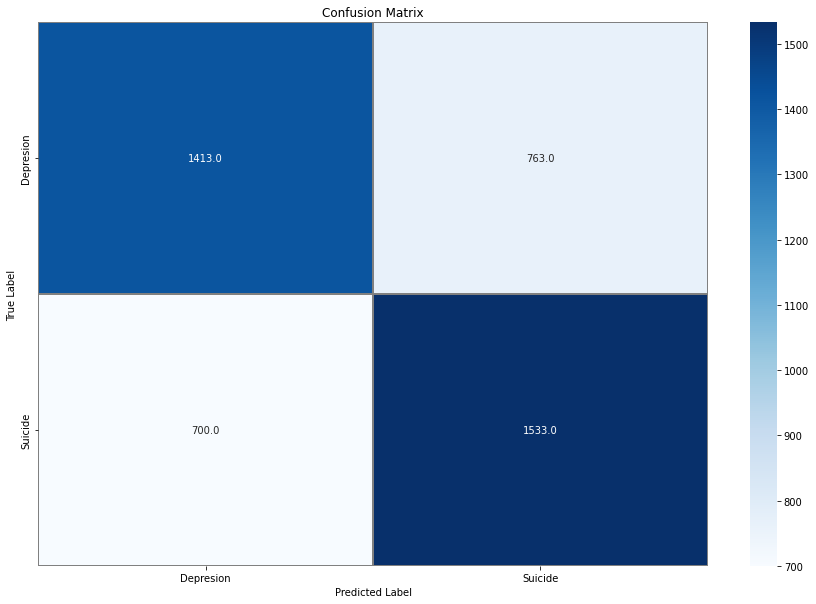

In [ ]:
model_func('ConvLSTM', 'pre_text_stem', epochs=7)

8) ConvLSTM model with spacy emmatize text

Epoch 1/7
322/322 [==============================] - 362s 1s/step - loss: 0.6141 - accuracy: 0.6495 - val_loss: 0.5506 - val_accuracy: 0.7149
Epoch 2/7
322/322 [==============================] - 365s 1s/step - loss: 0.4650 - accuracy: 0.7838 - val_loss: 0.5575 - val_accuracy: 0.7129
Epoch 3/7
322/322 [==============================] - 365s 1s/step - loss: 0.3379 - accuracy: 0.8545 - val_loss: 0.6937 - val_accuracy: 0.6831
Epoch 4/7
322/322 [==============================] - 369s 1s/step - loss: 0.2248 - accuracy: 0.9103 - val_loss: 0.8389 - val_accuracy: 0.6807
Epoch 5/7
322/322 [==============================] - 374s 1s/step - loss: 0.1569 - accuracy: 0.9398 - val_loss: 0.8776 - val_accuracy: 0.6441
Epoch 6/7
322/322 [==============================] - 364s 1s/step - loss: 0.1139 - accuracy: 0.9556 - val_loss: 1.2867 - val_accuracy: 0.6602
Epoch 7/7
138/138 [==============================] - 17s 119ms/step
              precision    recall  f1-score   support

           0       0.67  

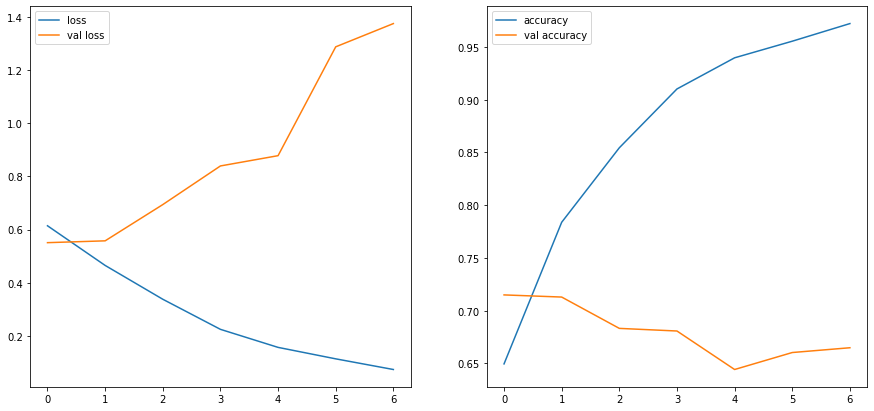

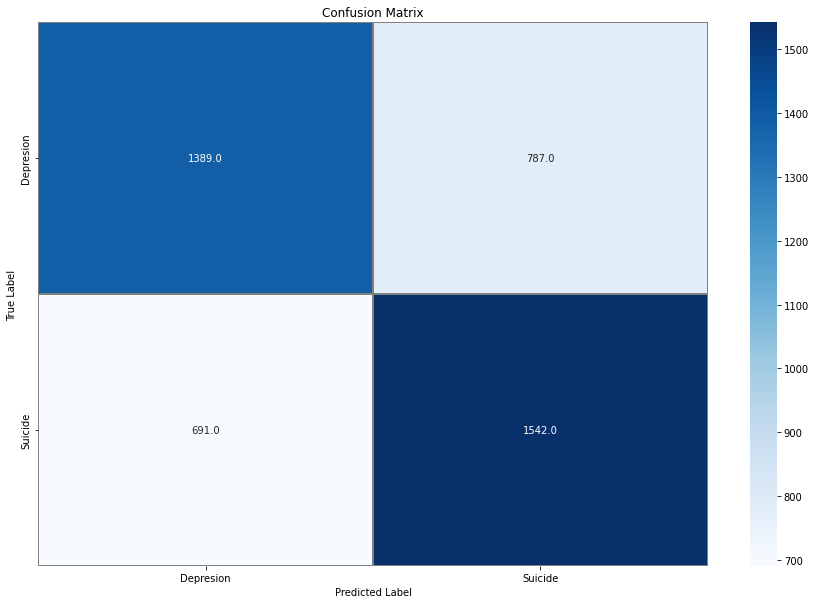

In [ ]:
model_func('ConvLSTM', 'pre_text_spacy', epochs=7)

#RNN

9) RNN model with normal text

Epoch 1/5
322/322 [==============================] - 392s 1s/step - loss: 0.6433 - accuracy: 0.6151 - val_loss: 0.5636 - val_accuracy: 0.7176
Epoch 2/5
322/322 [==============================] - 371s 1s/step - loss: 0.5263 - accuracy: 0.7624 - val_loss: 0.5510 - val_accuracy: 0.7169
Epoch 3/5
322/322 [==============================] - 371s 1s/step - loss: 0.4316 - accuracy: 0.8207 - val_loss: 0.5847 - val_accuracy: 0.7124
Epoch 4/5
322/322 [==============================] - 376s 1s/step - loss: 0.3685 - accuracy: 0.8549 - val_loss: 0.6543 - val_accuracy: 0.7031
Epoch 5/5
138/138 [==============================] - 17s 117ms/step
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      2176
           1       0.70      0.74      0.72      2233

    accuracy                           0.71      4409
   macro avg       0.71      0.70      0.70      4409
weighted avg       0.71      0.71      0.70      4409



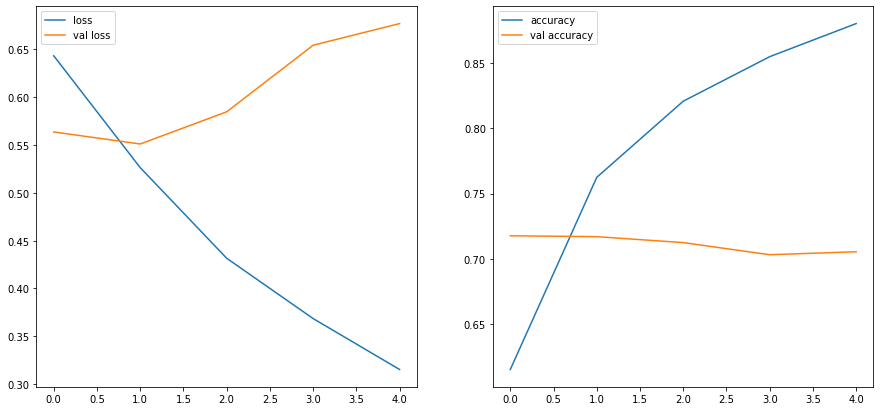

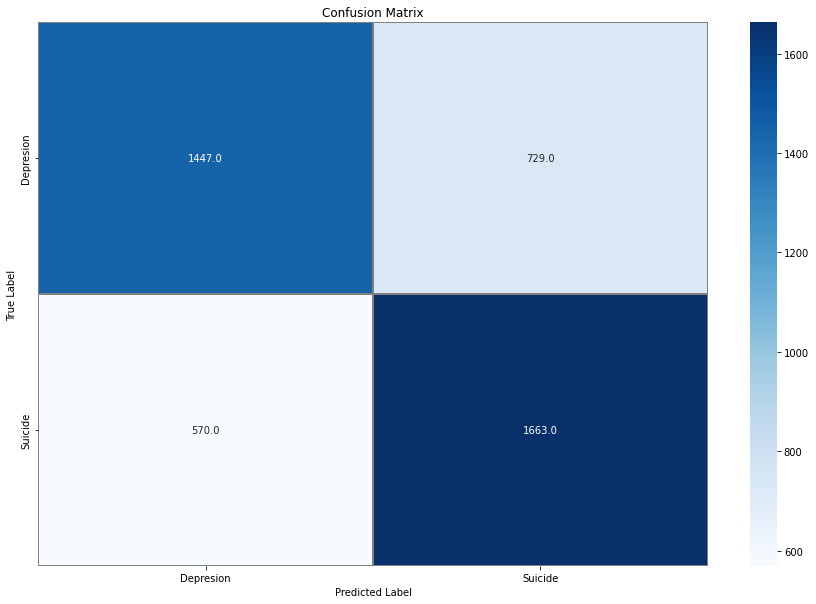

In [ ]:
model_func('rnn', 'pre_text', epochs=5)

10) RNN model with text lemmatize

Epoch 1/5
322/322 [==============================] - 390s 1s/step - loss: 0.6443 - accuracy: 0.6232 - val_loss: 0.5716 - val_accuracy: 0.7088
Epoch 2/5
322/322 [==============================] - 378s 1s/step - loss: 0.5281 - accuracy: 0.7590 - val_loss: 0.5797 - val_accuracy: 0.6918
Epoch 3/5
322/322 [==============================] - 378s 1s/step - loss: 0.4454 - accuracy: 0.8136 - val_loss: 0.5727 - val_accuracy: 0.7101
Epoch 4/5
322/322 [==============================] - 375s 1s/step - loss: 0.3781 - accuracy: 0.8471 - val_loss: 0.6620 - val_accuracy: 0.7051
Epoch 5/5
138/138 [==============================] - 16s 113ms/step
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      2176
           1       0.67      0.77      0.72      2233

    accuracy                           0.69      4409
   macro avg       0.70      0.69      0.69      4409
weighted avg       0.70      0.69      0.69      4409



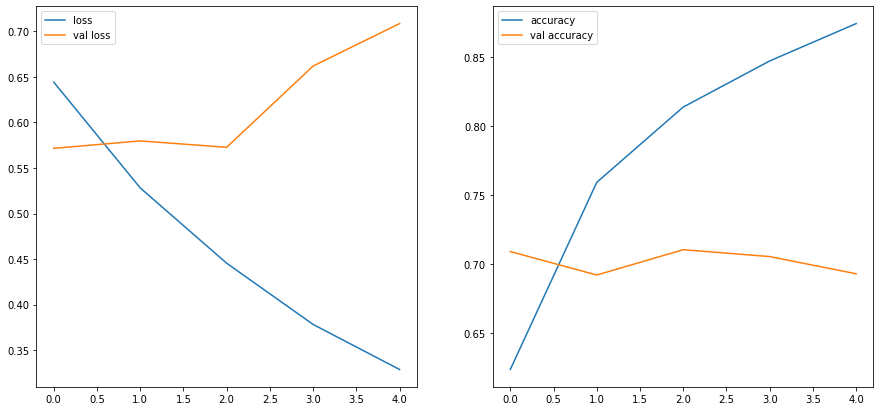

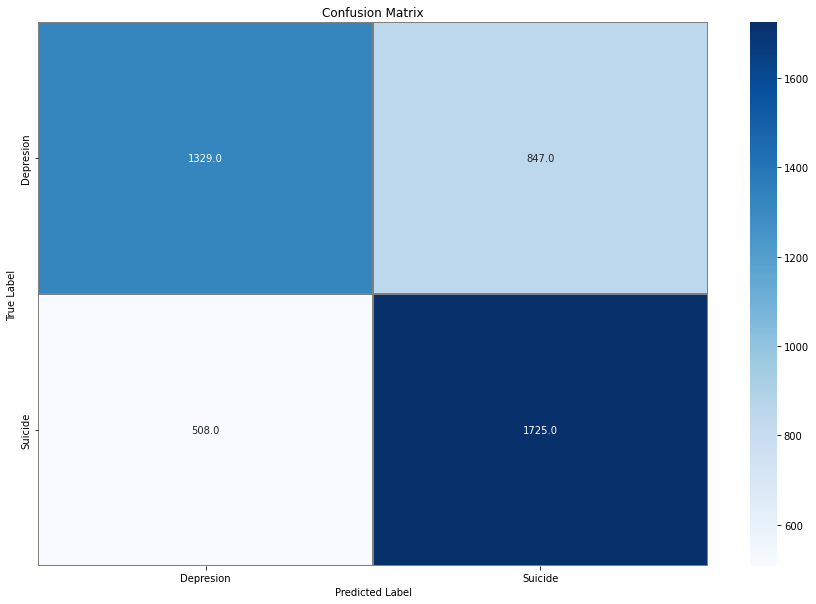

In [43]:
model_func('rnn', 'pre_text_lemma', epochs=5)

11) RNN model with stemming text

Epoch 1/5
322/322 [==============================] - 380s 1s/step - loss: 0.6465 - accuracy: 0.6247 - val_loss: 0.5632 - val_accuracy: 0.7169
Epoch 2/5
322/322 [==============================] - 377s 1s/step - loss: 0.5505 - accuracy: 0.7437 - val_loss: 0.5493 - val_accuracy: 0.7226
Epoch 3/5
322/322 [==============================] - 375s 1s/step - loss: 0.4763 - accuracy: 0.7910 - val_loss: 0.5688 - val_accuracy: 0.7135
Epoch 4/5
322/322 [==============================] - 374s 1s/step - loss: 0.4146 - accuracy: 0.8286 - val_loss: 0.6319 - val_accuracy: 0.7081
Epoch 5/5
138/138 [==============================] - 17s 119ms/step
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      2176
           1       0.69      0.73      0.71      2233

    accuracy                           0.70      4409
   macro avg       0.70      0.70      0.70      4409
weighted avg       0.70      0.70      0.70      4409



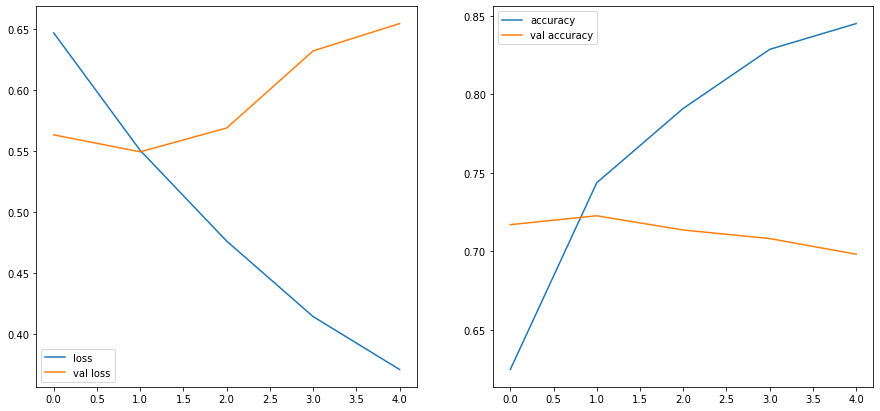

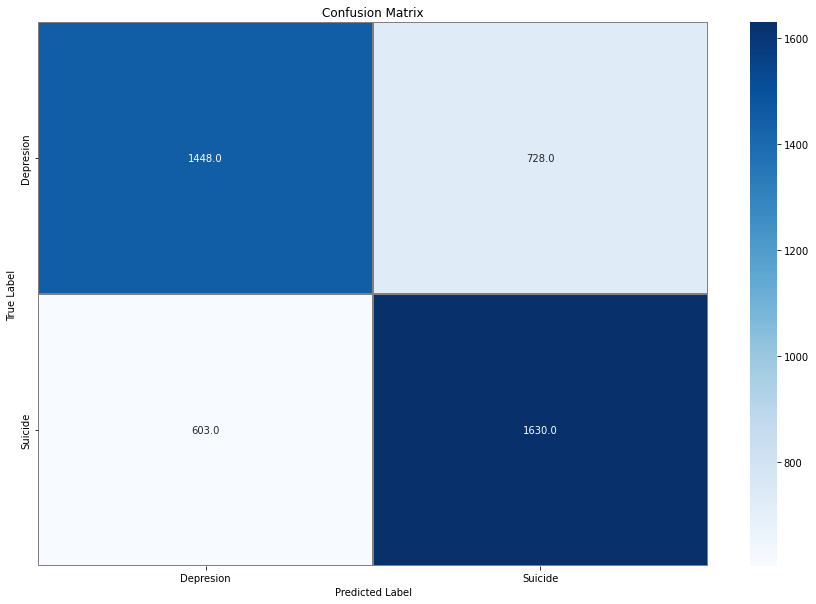

In [44]:
model_func('rnn', 'pre_text_stem', epochs=5)

12) RNN model with spacy emmatize text

Epoch 1/5
322/322 [==============================] - 384s 1s/step - loss: 0.6504 - accuracy: 0.6197 - val_loss: 0.5678 - val_accuracy: 0.7199
Epoch 2/5
322/322 [==============================] - 369s 1s/step - loss: 0.5415 - accuracy: 0.7481 - val_loss: 0.5524 - val_accuracy: 0.7274
Epoch 3/5
322/322 [==============================] - 377s 1s/step - loss: 0.4700 - accuracy: 0.8078 - val_loss: 0.5752 - val_accuracy: 0.7058
Epoch 4/5
322/322 [==============================] - 381s 1s/step - loss: 0.3957 - accuracy: 0.8430 - val_loss: 0.6359 - val_accuracy: 0.6995
Epoch 5/5
138/138 [==============================] - 16s 113ms/step
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      2176
           1       0.71      0.68      0.69      2233

    accuracy                           0.70      4409
   macro avg       0.70      0.70      0.70      4409
weighted avg       0.70      0.70      0.70      4409



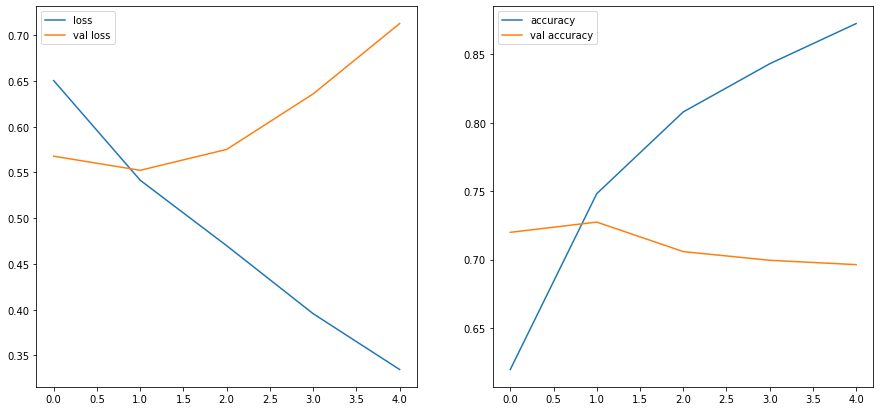

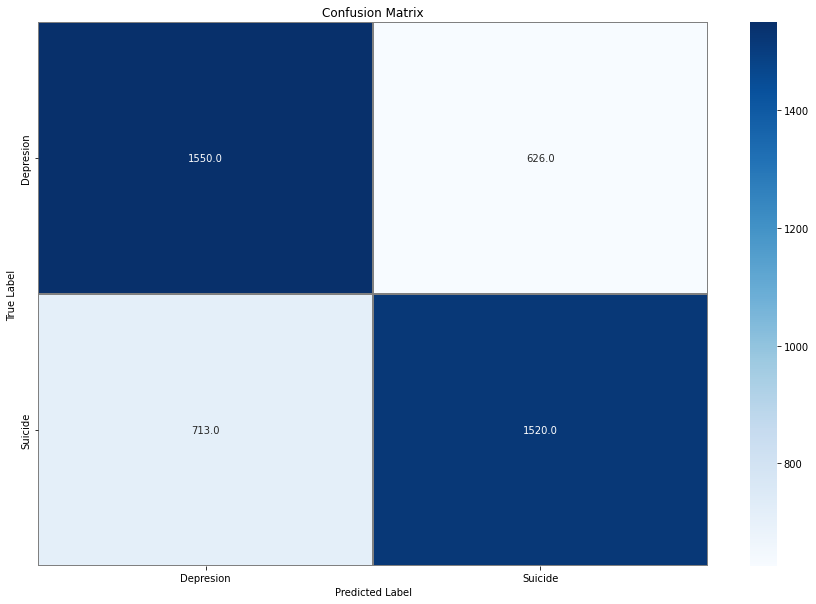

In [45]:
model_func('rnn', 'pre_text_spacy', epochs=5)